# Homework 4: AppliedML
## Deadline

Wednesday, November 22, 2017, 11:59PM

In [3]:
import csv
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import networkx as nx

from sklearn import linear_model
from sklearn.preprocessing import StandardScaler

In [4]:
df = pd.DataFrame.from_csv('lalonde.csv')
df.shape

(614, 10)

## Question 1: Propensity score matching

In this exercise, you will apply [propensity score matching](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf), which we discussed in lecture 5 ("Observational studies"), in order to draw conclusions from an observational study.

We will work with a by-now classic dataset from Robert LaLonde's study "[Evaluating the Econometric Evaluations of Training Programs](http://people.hbs.edu/nashraf/LaLonde_1986.pdf)" (1986).
The study investigated the effect of a job training program ("National Supported Work Demonstration") on the real earnings of an individual, a couple of years after completion of the program.
Your task is to determine the effectiveness of the "treatment" represented by the job training program.

#### Dataset description

- `treat`: 1 if the subject participated in the job training program, 0 otherwise
- `age`: the subject's age
- `educ`: years of education
- `race`: categorical variable with three possible values: Black, Hispanic, or White
- `married`: 1 if the subject was married at the time of the training program, 0 otherwise
- `nodegree`: 1 if the subject has earned no school degree, 0 otherwise
- `re74`: real earnings in 1974 (pre-treatment)
- `re75`: real earnings in 1975 (pre-treatment)
- `re78`: real earnings in 1978 (outcome)

If you want to brush up your knowledge on propensity scores and observational studies, we highly recommend Rosenbaum's excellent book on the ["Design of Observational Studies"](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf). Even just reading the first chapter (18 pages) will help you a lot.

#### 1. A naive analysis

Compare the distribution of the outcome variable (`re78`) between the two groups, using plots and numbers.
To summarize and compare the distributions, you may use the techniques we discussed in lectures 4 ("Read the stats carefully") and 6 ("Data visualization").

What might a naive "researcher" conclude from this superficial analysis?

#### Explication:

We first compute the number of subjects in each group with its mean and standard deviation.

185 subjects participated in job trainings with an average earning in 1978 of 6349.14 (+/- 7867.40)
429 subjects did not participated in job trainings with an average earning in 1978 of 6984.17 (+/- 7294.16)


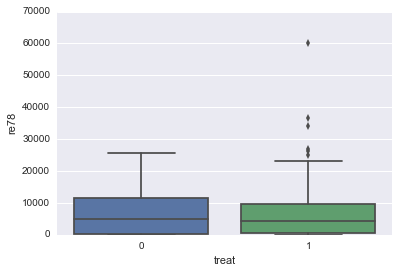

In [5]:
# Print the distributions and details
re78_treat = df['re78'][df['treat']==1]
re78_notreat = df['re78'][df['treat']==0]
print('%d subjects participated in job trainings with an average earning in 1978 of %.2f (+/- %.2f)' % (len(re78_treat), re78_treat.mean(), re78_treat.std()))
print('%d subjects did not participated in job trainings with an average earning in 1978 of %.2f (+/- %.2f)' % (len(re78_notreat), re78_notreat.mean(), re78_notreat.std()))
sns.boxplot(x='treat', y='re78', data=df)
plt.show()

Note that there are few outliers for the "treated" group but overall, the mean is slightly higher for the none "treated" group.  
  
We then plot the two distributions without looking closely at the data in order to have a first insight.

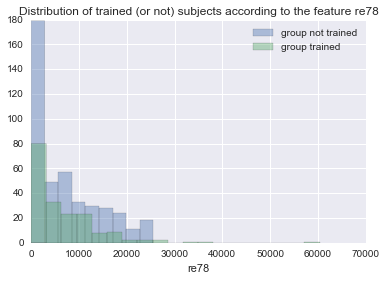

In [8]:
# Function to plot the distribution of one feature according to 'treat'
def plot_dist(feature, ax, df=df):
    treat = df[feature][df['treat']==1]
    notreat = df[feature][df['treat']==0]
    sns.distplot(notreat, kde=False, label='group not trained', ax=ax)
    sns.distplot(treat, kde=False, label='group trained', ax=ax)
    ax.set_title('Distribution of trained (or not) subjects according to the feature ' + feature)
fig, ax = plt.subplots()
plot_dist('re78', ax=ax)
plt.legend();

Note that the peaks in the first bars is due to the fact that there are a lot of people with zero real earnings, i.e. unemployed. Of course we need to keep it as it provides information. 
  
We may now want to normalize the distribution as there is much more subjects that did not participated in job trainings.

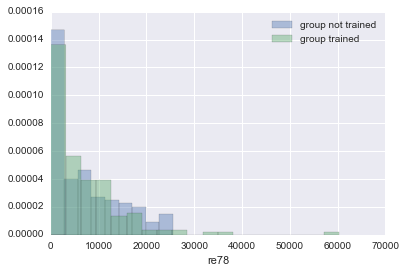

In [9]:
sns.distplot(re78_notreat, kde=False, norm_hist=True, label='group not trained')
sns.distplot(re78_treat, kde=False, norm_hist=True, label='group trained')
plt.legend()
plt.show()

Given the mean of the two different groups and the distribution, a naive "researcher" would conclude that subjects who participated in job trainings earn less than those who did not.

#### 2. A closer look at the data

You're not naive, of course (and even if you are, you've learned certain things in ADA), so you aren't content with a superficial analysis such as the above.
You're aware of the dangers of observational studies, so you take a closer look at the data before jumping to conclusions.

For each feature in the dataset, compare its distribution in the treated group with its distribution in the control group, using plots and numbers.
As above, you may use the techniques we discussed in class for summarizing and comparing the distributions.

What do you observe?
Describe what your observations mean for the conclusions drawn by the naive "researcher" from his superficial analysis.

#### Explication:
To have a closer look at the data, we plot the distributions for all features with respect to the feature 'treat'. For the quantitative features, we compute the mean and the standard deviation using a boxplot.

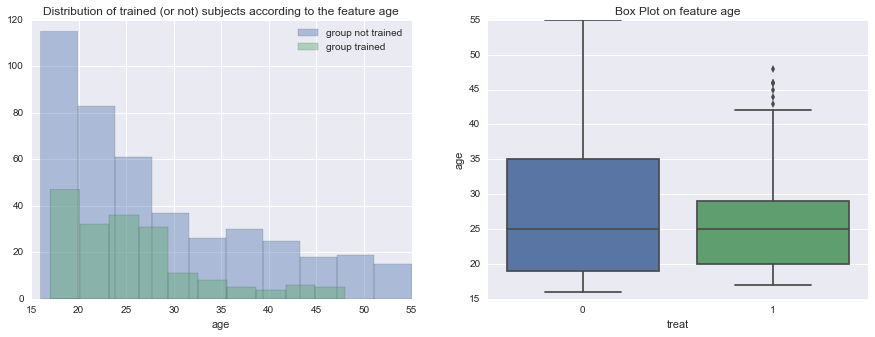

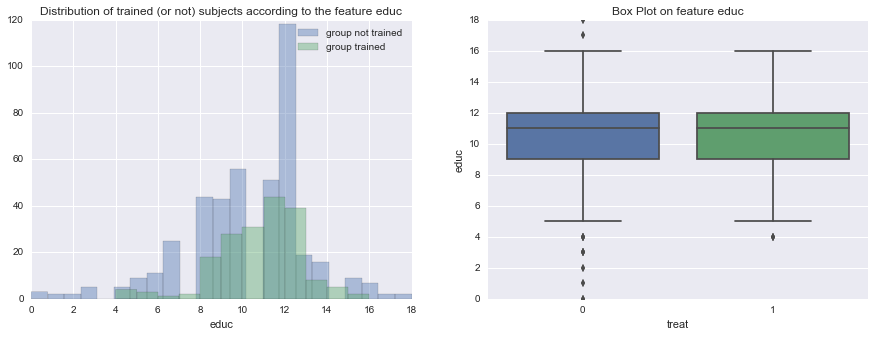

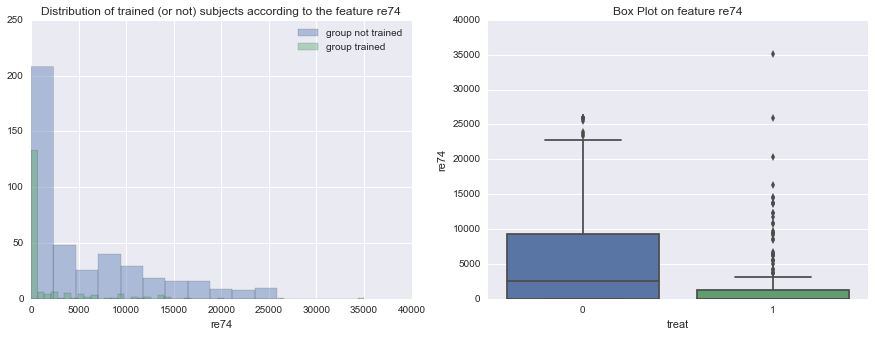

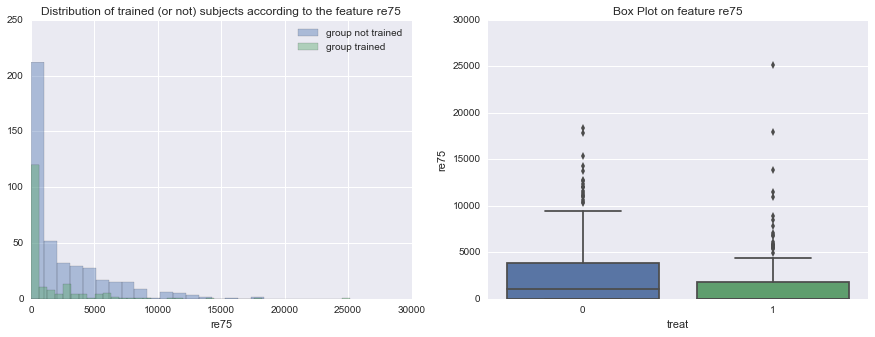

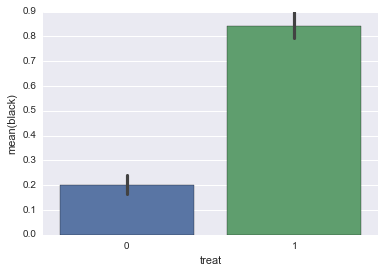

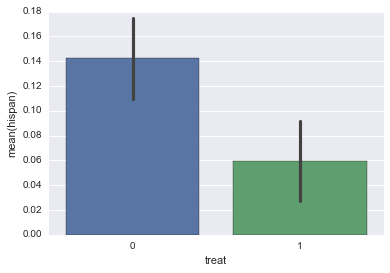

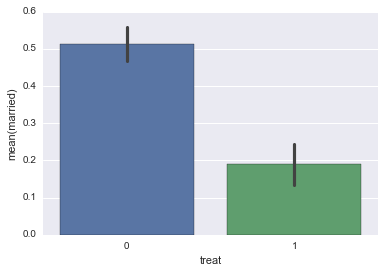

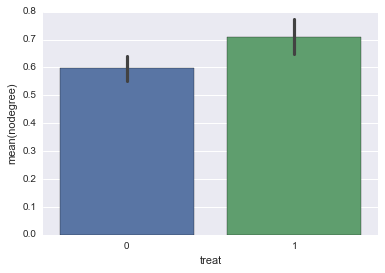

In [10]:
numerical_features = ['age', 'educ', 're74', 're75']
colname_hist = ['black', 'hispan', 'married', 'nodegree']

for feature in numerical_features:
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
    plot_dist(feature, ax=ax1)
    ax1.legend()
    sns.boxplot(x='treat', y=feature, data=df, ax=ax2)
    plt.title('Box Plot on feature '+ feature)
    plt.show()
    
for feature in colname_hist:
    sns.barplot(x='treat', y=feature, data=df)
    plt.show()

It might be hard to see the difference of proportion with the features for the binary, we will hence focus on them in order to be able to compare them.
##### Distribution of binary features    
We want to explore the features that are binary in our dataset, with count and bar plot.   
'control_0' corresponds to when the feature is 0 for control. 

In [31]:
# Init the useful dataframes for treated and control subject
treated = df[df.treat == 1]
control = df[df.treat == 0]

index_name = ['control_0', 'control_1', 'treatment_0', 'treatment_1']

def create_count_df(df, norm=False):
# df : rows : treatment_0, treatment_1, control_0, control_1
#      cols : hisp, black, degree, married -> colname_hist
    count_df = pd.DataFrame(columns = colname_hist, index = index_name)
    for i in range(0,4): 

        # Extract treatment then control from global dataframe
        temp_df = df[df['treat'] == int(i/2)]
        
        # Get total number of subjects to normalize if needed
        total_number = len(temp_df) if norm else 1
        
        # Extract number of subjects in one binary feature being 0 or 1 from treatment then control
        count_df.loc[index_name[i]] = [temp_df[feature][temp_df[feature]==i%2].count()/total_number for feature in colname_hist]

    # Transpose dataframe to get features as rows
    count_df = count_df.transpose()
    
    # Compute the standard deviations if we normalize
    if norm:
        count_df['error_control'] = count_df['control_0']*count_df['control_1']/len(control)
        count_df['error_control'] = np.sqrt(count_df[['error_control']].sum(axis=1))
        count_df['error_treatment'] = ((np.array(count_df['treatment_0']*count_df['treatment_1']/len(treated))))
        count_df['error_treatment'] = np.sqrt(count_df[['error_treatment']].sum(axis=1))
    return count_df
count_df = create_count_df(df)
count_df

,control_0,control_1,treatment_0,treatment_1
black,342,87,29,156
hispan,368,61,174,11
married,209,220,150,35
nodegree,173,256,54,131


##### Normalized distribution of binary features 
We now do the same but we normalize the data this time to visualize both.

Compute error bar for control and treatment.    
As it is a mean of Bernouilli variable, its variance is (central limit theorem) :   
$$\sqrt{\frac{p(1-p)}{n}}$$

In [32]:
count_df_norm = create_count_df(df, norm=True)
count_df_norm

,control_0,control_1,treatment_0,treatment_1,error_control,error_treatment
black,0.797203,0.202797,0.156757,0.843243,0.019413,0.026730
hispan,0.857809,0.142191,0.940541,0.0594595,0.016862,0.017387
married,0.487179,0.512821,0.810811,0.189189,0.024132,0.028795
nodegree,0.403263,0.596737,0.291892,0.708108,0.023684,0.033425


##### Plotting 

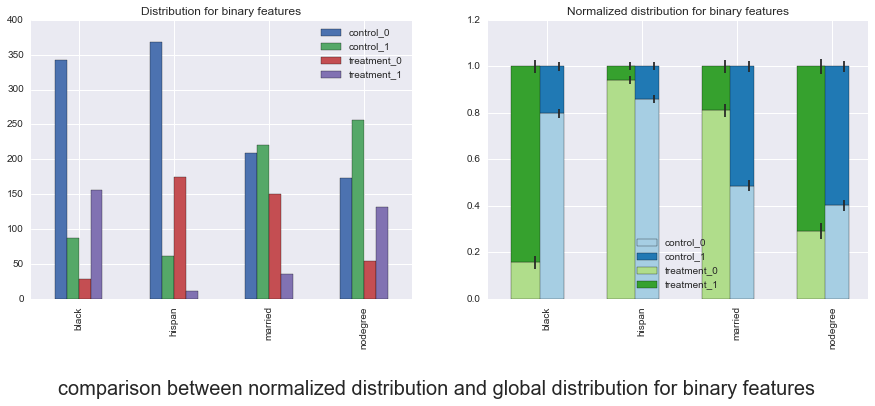

In [34]:
def plot_bin_features(count_df, count_df_norm):
    # Two subplots, unpack the axes array immediately
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=((15,5)))
    count_df.plot.bar(ax = ax1,
                      legend=True,
                      title= "Distribution for binary features")


    colors = sns.color_palette("Paired", n_colors=5)


    count_df_norm[['control_0','control_1']].plot.bar(ax=ax2,
                                                      legend=True,
                                                      title="Normalized distribution for binary features",
                                                      label = 'control',
                                                      stacked=True,
                                                      color = colors,
                                                      yerr= count_df_norm['error_control'],
                                                      position=0.25)

    count_df_norm[['treatment_0','treatment_1']].plot.bar(ax=ax2,
                                                          legend=True, 
                                                          title="Normalized distribution for binary features",
                                                          label='treatment',
                                                          stacked=True,
                                                          color = colors[2:],
                                                          yerr= count_df_norm['error_treatment'], 
                                                          position=0.75)

    # Change the width of the bars
    h,l = ax2.get_legend_handles_labels() 
    width=0.3
    for i in range(0, 4, 2): 
        for container in h[i:i+2]:
            for bar in container.patches: 
                bar.set_width(width)


    plt.suptitle("comparison between normalized distribution and global distribution for binary features",
                 fontsize=20,
                 y = -0.1,
                )


    plt.show()
plot_bin_features(count_df, count_df_norm)

The first conclusion that we have drawn is 'superficial' in the sense that a lot of other factors that we did not take into account might biased the results. Indeed, if we look at the distributions of the features, we observe a big difference between the values whether we lie in the treat or a control subject. Hence, we compare very different profiles and all put them in the same box...  
  
For example, we would compare the real earning of a black married person with 8 years of education with a white unmarried person that has no degree. Of course those previous factors might affect the resulting earnings (and not only whether they ever had a job training).

#### 3. A propensity score model

Use logistic regression to estimate propensity scores for all points in the dataset.
You may use `sklearn` to fit the logistic regression model and apply it to each data point to obtain propensity scores:

```python
from sklearn import linear_model
logistic = linear_model.LogisticRegression()
```

Recall that the propensity score of a data point represents its probability of receiving the treatment, based on its pre-treatment features (in this case, age, education, pre-treatment income, etc.).
To brush up on propensity scores, you may read chapter 3.3 of the above-cited book by Rosenbaum or [this article](https://drive.google.com/file/d/0B4jctQY-uqhzTlpBaTBJRTJFVFE/view).

Note: you do not need a train/test split here. Train and apply the model on the entire dataset. If you're wondering why this is the right thing to do in this situation, recall that the propensity score model is not used in order to make predictions about unseen data. Its sole purpose is to balance the dataset across treatment groups.
(See p. 74 of Rosenbaum's book for an explanation why slight overfitting is even good for propensity scores.
If you want even more information, read [this article](https://drive.google.com/file/d/0B4jctQY-uqhzTlpBaTBJRTJFVFE/view).)

#### Explication:

As stated above, the propensity score is the probability of receiving the treatment, knowing its pre-treatment features. We hence use logistic regression to predict the probability of treatment which is itself the propensity score. Note that we do not include 're87' as it is not a pre-treatment feature.

In [18]:
# Split feature columns and predictors
X = df.iloc[:, 1:9]
y = df.iloc[:, 0]

# Scale the data in order to apply meaningfully the logistic regression
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

# Fit the logistic regression
logistic = linear_model.LogisticRegression()
logistic.fit(X, y)

# Predict the treatment using the model
pred_proba_treat = logistic.predict_proba(X)[:,1]

# Create a new dataframe with the propensity score
df_propensity = df.copy()
df_propensity['propensity score'] = pred_proba_treat
df_propensity.head()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,propensity score
id,,,,,,,,,,,
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,0.634047
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,0.224985
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,0.676130
NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,0.770728
NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,0.699798


#### 4. Balancing the dataset via matching

Use the propensity scores to match each data point from the treated group with exactly one data point from the control group, while ensuring that each data point from the control group is matched with at most one data point from the treated group.
(Hint: you may explore the `networkx` package in Python for predefined matching functions.)

Your matching should maximize the similarity between matched subjects, as captured by their propensity scores.
In other words, the sum (over all matched pairs) of absolute propensity-score differences between the two matched subjects should be minimized.

After matching, you have as many treated as you have control subjects.
Compare the outcomes (`re78`) between the two groups (treated and control).

Also, compare again the feature-value distributions between the two groups, as you've done in part 2 above, but now only for the matched subjects.
What do you observe?
Are you closer to being able to draw valid conclusions now than you were before?

#### Explication:
As the similarity needs to be maximized only between matched subjects and given that we have less treated subjects, we need to find the minimum distance for each treated subject among all control subject. Note that the distance is simply the difference between the two propensity scores.  
  
In order to do the matching, we create a bipartite graph with the left nodes being the treated subjects and the right nodes being the control subjects. We create one edge between each nodes on the left side to each nodes on the right side. The weight is the absolute value of the difference between the propensity scores. Since we need to minimize those weight, it is equivalent to maximize the opposite of these values (by multiplying by -1). We can hence use the function `max_weight_matching` from networkx to do the matching.

In [19]:
# Create the graph using networkx
g = nx.Graph()
# Create the bipartite graph by iterating over the treated subjects and then the not treated ones
for i in df[df['treat']==1].index:
    for j in df[df['treat']==0].index:
        # Create an edge with weight = - abs(prop_score_treated - prop_score_notreated)
        # Note the minus in order to maximize instead of minimizing
        g.add_edge(i, j, weight=-abs(df_propensity.loc[i]['propensity score'] - df_propensity.loc[j]['propensity score']))

In [20]:
# Do the matching according to the max weight
matching = nx.algorithms.max_weight_matching(g, maxcardinality=True)

In [21]:
# Create the dataframe to store our results
df_balanced = pd.DataFrame([df.loc[x] for x in matching])

# Check that the data is indeed balanced
print('# of treated subjects :', len(df_balanced[df_balanced['treat']==1]))
print('# of control subjects :', len(df_balanced[df_balanced['treat']==0]))

# of treated subjects : 185
# of control subjects : 185


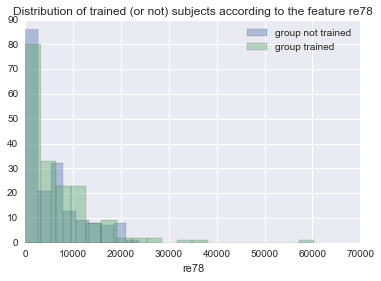

185 subjects participated in job trainings with an average earning in 1978 of 6349.14 (+/- 7867.40)
185 subjects did not participated in job trainings with an average earning in 1978 of 5392.10 (+/- 5928.20)


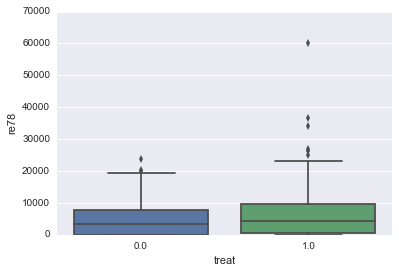

In [25]:
fig, ax = plt.subplots()
plot_dist('re78', df=df_balanced, ax=ax)
plt.legend()
plt.show()
# Print the distributions and details
re78_treat_balanced = df_balanced['re78'][df_balanced['treat']==1]
re78_notreat_balanced = df_balanced['re78'][df_balanced['treat']==0]
print('%d subjects participated in job trainings with an average earning in 1978 of %.2f (+/- %.2f)' % (len(re78_treat_balanced), re78_treat_balanced.mean(), re78_treat_balanced.std()))
print('%d subjects did not participated in job trainings with an average earning in 1978 of %.2f (+/- %.2f)' % (len(re78_notreat_balanced), re78_notreat_balanced.mean(), re78_notreat_balanced.std()))
sns.boxplot(x='treat', y='re78', data=df_balanced)
plt.show()

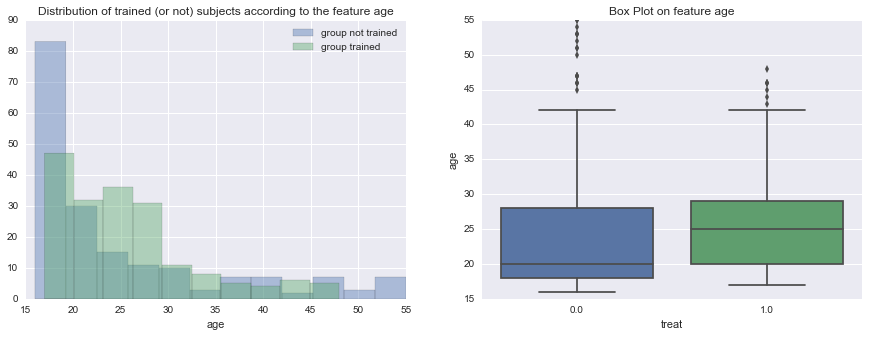

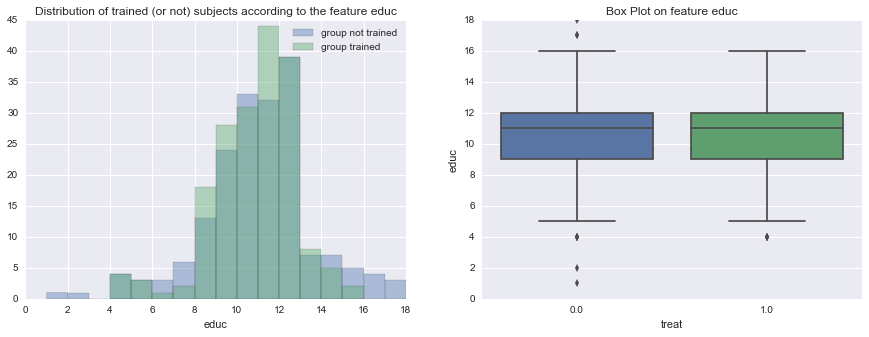

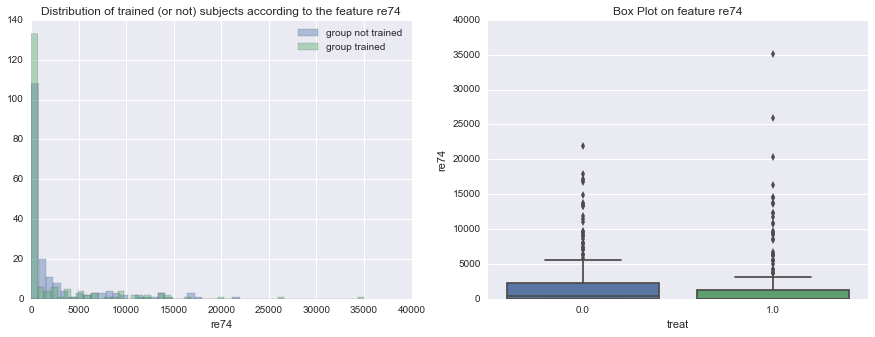

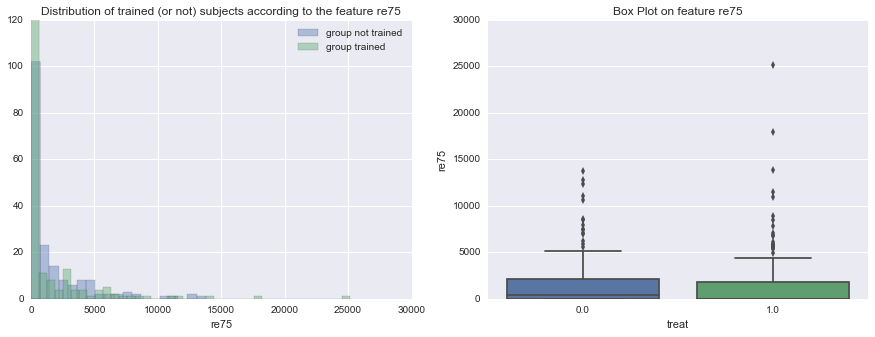

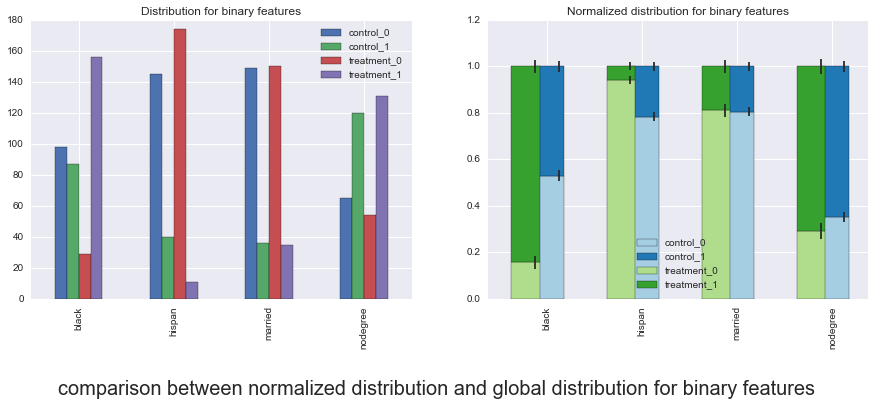

In [36]:
# Redo the distribution insight as for Part 2
for feature in numerical_features:
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
    plot_dist(feature, df=df_balanced, ax=ax1)
    ax1.legend()
    sns.boxplot(x='treat', y=feature, data=df_balanced, ax=ax2)
    plt.title('Box Plot on feature '+ feature)
    plt.show()
    
# For the binary features, we directly plot our second analysis
count_df_balanced = create_count_df(df=df_balanced)
count_df_norm_balanced = create_count_df(df=df_balanced, norm=True)
plot_bin_features(count_df_balanced, count_df_norm_balanced)

First we note that the average real earnings is now much lower for the control subjects. Hence, from this analysis job trainings are advised. Moreover, from the above analysis, we observe that feature values are much closer with respect to treat/control subjects.  
  
As we compare similar profiles, our analysis makes more sense and we are more likely to make a valid conclusion here than in the previous parts.

#### 5. Balancing the groups further

Based on your comparison of feature-value distributions from part 4, are you fully satisfied with your matching?
Would you say your dataset is sufficiently balanced?
If not, in what ways could the "balanced" dataset you have obtained still not allow you to draw valid conclusions?

Improve your matching by explicitly making sure that you match only subjects that have the same value for the problematic feature.
Argue with numbers and plots that the two groups (treated and control) are now better balanced than after part 4.

#### Explication:

We are still far from comparing exactly the same profiles. The main feature that we need t work on is the race. Indeed the proportion of 'black' is not the same at all in the control and treat subject group.
  
In order to do the matching we need to get rid of the edges where the features are not matching and do the same steps as above.

In [37]:
g_race = nx.Graph()
# Create the bipartite graph by iterating over the treated subjects and then the not treated ones
for i in df_propensity[df_propensity['treat']==1].index:
    for j in df_propensity[df_propensity['treat']==0].index:
        # We only connect if the races are matching
        if df_propensity.loc[i]['black'] == df_propensity.loc[j]['black'] and df_propensity.loc[i]['hispan'] == df_propensity.loc[j]['hispan']:
            g_race.add_edge(i, j, weight=-abs(df_propensity.loc[i]['propensity score'] - df_propensity.loc[j]['propensity score']))

In [38]:
# Do the matching according to the max weight
race_matching = nx.algorithms.max_weight_matching(g_race, maxcardinality=True)

# Create a dataframe with the resulting matches
df_race_balanced = pd.DataFrame([df.loc[x] for x in race_matching])

# Check that the data is indeed balanced
print('# of treated subjects :', len(df_race_balanced[df_race_balanced['treat']==1]))
print('# of control subjects :', len(df_race_balanced[df_race_balanced['treat']==0]))

# of treated subjects : 116
# of control subjects : 116


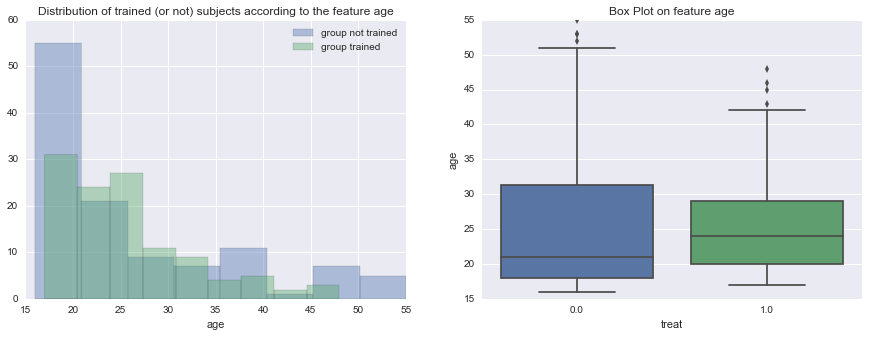

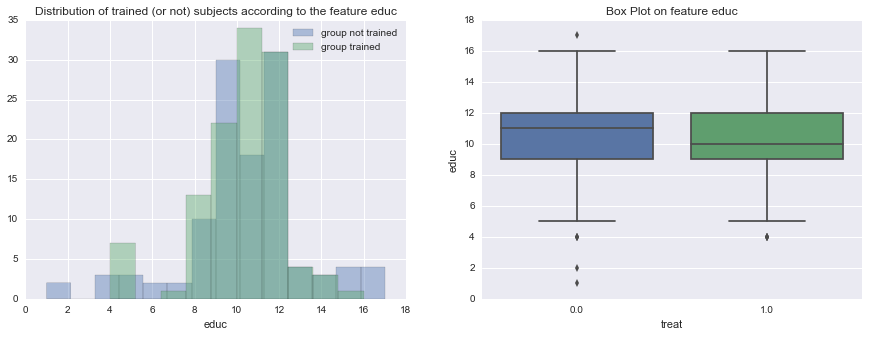

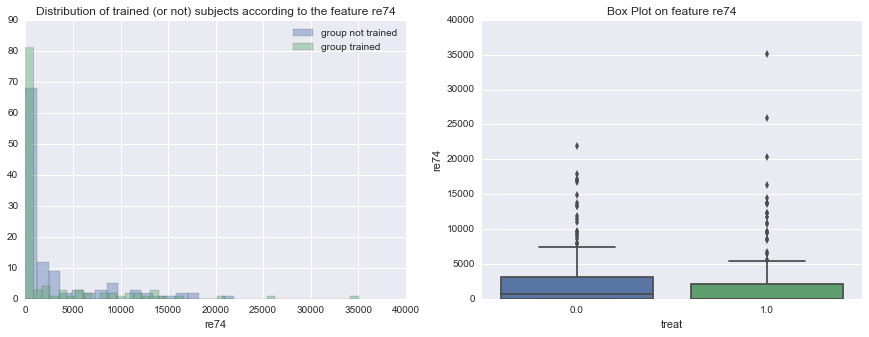

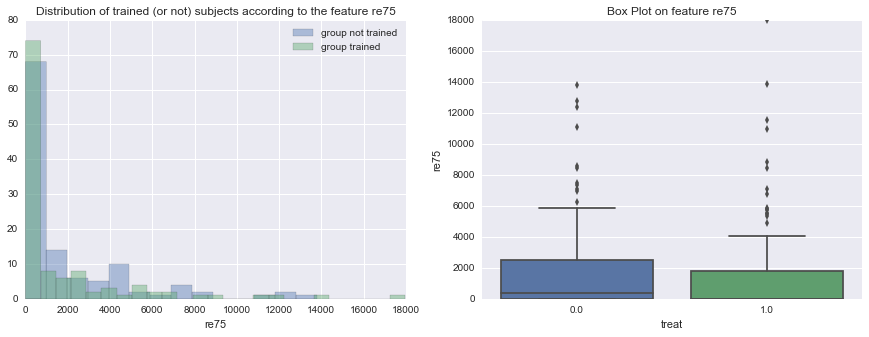

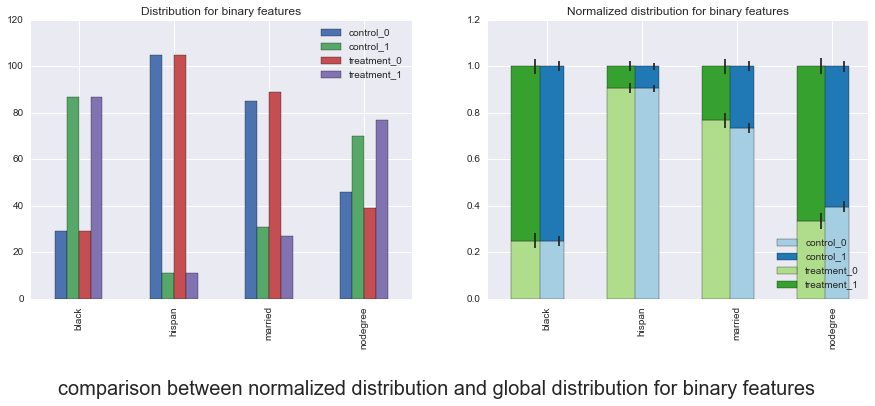

In [39]:
# Redo the distribution insight as for Part 2
for feature in numerical_features:
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
    plot_dist(feature, df=df_race_balanced, ax=ax1)
    ax1.legend()
    sns.boxplot(x='treat', y=feature, data=df_race_balanced, ax=ax2)
    plt.title('Box Plot on feature '+ feature)
    plt.show()
    
# For the binary features, we directly plot our second analysis
count_df_race = create_count_df(df=df_race_balanced)
count_df_norm_race = create_count_df(df=df_race_balanced, norm=True)
plot_bin_features(count_df_race, count_df_norm_race)

From the distribution plots, we can see that the proportion of different race (white, clabk and hispan) is now the same. We could still work on some other features such as 'age' or 'married' but as we only have 116 subjects for each groups (treat/control) we will not reduce more our datset.

#### 6. A less naive analysis

Compare the outcomes (`re78`) between treated and control subjects, as you've done in part 1, but now only for the matched dataset you've obtained from part 5.
What do you conclude about the effectiveness of the job training program?

#### Explication:

Again here, we plot the distribution and compute the mean and std for the real earnings in 1978.

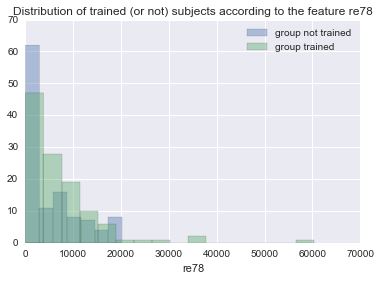

116 subjects participated in job trainings with an average earning in 1978 of 7070.71 (+/- 8607.70)
116 subjects did not participated in job trainings with an average earning in 1978 of 4968.64 (+/- 5855.64)


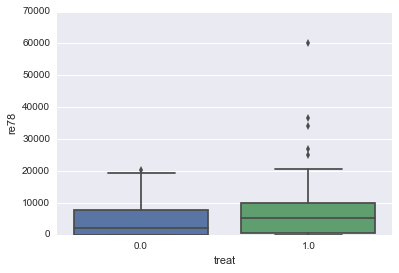

In [29]:
plot_dist('re78', df=df_race_balanced)
plt.show()
# Print the distributions and details
re78_treat_race_balanced = df_race_balanced['re78'][df_race_balanced['treat']==1]
re78_notreat_race_balanced = df_race_balanced['re78'][df_race_balanced['treat']==0]
print('%d subjects participated in job trainings with an average earning in 1978 of %.2f (+/- %.2f)' % (len(re78_treat_race_balanced), re78_treat_race_balanced.mean(), re78_treat_race_balanced.std()))
print('%d subjects did not participated in job trainings with an average earning in 1978 of %.2f (+/- %.2f)' % (len(re78_notreat_race_balanced), re78_notreat_race_balanced.mean(), re78_notreat_race_balanced.std()))
sns.boxplot(x='treat', y='re78', data=df_race_balanced)
plt.show()

Given this more detailed analysis, we can see that in average, subjects that participated in a job training earn more money than if they didn't. It is interesting to note that in our first naive observation it was the other way around which shows the importance of a good study of the provided data.


## Question 2: Applied ML

We are going to build a classifier of news to directly assign them to 20 news categories. Note that the pipeline that you will build in this exercise could be of great help during your project if you plan to work with text!

1. Load the 20newsgroup dataset. It is, again, a classic dataset that can directly be loaded using sklearn ([link](http://scikit-learn.org/stable/datasets/twenty_newsgroups.html)).  
[TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf), short for term frequency–inverse document frequency, is of great help when if comes to compute textual features. Indeed, it gives more importance to terms that are more specific to the considered articles (TF) but reduces the importance of terms that are very frequent in the entire corpus (IDF). Compute TF-IDF features for every article using [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). Then, split your dataset into a training, a testing and a validation set (10% for validation and 10% for testing). Each observation should be paired with its corresponding label (the article category).


2. Train a random forest on your training set. Try to fine-tune the parameters of your predictor on your validation set using a simple grid search on the number of estimator "n_estimators" and the max depth of the trees "max_depth". Then, display a confusion matrix of your classification pipeline. Lastly, once you assessed your model, inspect the `feature_importances_` attribute of your random forest and discuss the obtained results.

Answer Q&A: Confusion matrix on test set, CV using GridsearchCV yes but explain. Distribution to show how many features are important for the model. One plot distribution is enough.

Relevant imports and downloading the dictionary. In the window that opens, you should choose "popular packages" to download the dictionnary of the lemmantizer used in the preprocessing.

In [20]:
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint
from random import shuffle
from gensim.parsing.preprocessing import STOPWORDS

import sklearn as sk
from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

import nltk
from nltk.stem import WordNetLemmatizer


nltk.download()

We now fetch the dataset

In [2]:
newsgroups_train = fetch_20newsgroups()
print("Article categories:")
pprint(list(newsgroups_train.target_names))

Article categories:
['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']


We remove the special characters. This is because for example if we have a word followed by a period the period will be added to the word, which will create unnecessary words.

We then remove the stop words (of, the , and...)

And finally we lemmantize the articles (By using a vocabulary and a morphological analysis of words, we returne to the base or dictionary form of a word)

In [3]:
articles_no_specials = []
# Removing the special characters.
for item in newsgroups_train.data:
    try:
        articles_no_specials.append(
            item.replace('\r', ' ').replace('/n', ' ').replace('.', ' ').replace(',', ' ').replace('(', ' ') \
                .replace(')', ' ').replace("'s", ' ').replace('"', ' ') \
                .replace('!', ' ').replace('?', ' ').replace("'", '') \
                .replace('>', ' ').replace('$', ' ') \
                .replace('-', ' ').replace(';', ' ') \
                .replace(':', ' ').replace('/', ' ').replace('#', ' '))
    except:
        articles_no_specials.append("")



# remove stop words and tokenize the words
articles_no_stop = []
for article in articles_no_specials:
    new_text = []
    for word in article.lower().split():
        if word not in STOPWORDS:
            new_text.append(word)
    articles_no_stop.append(new_text)

# lemmattizing tokens
lemmatizer = WordNetLemmatizer()
articles_no_stop_lemmatize = [[lemmatizer.lemmatize(token) for token in text]
                                          for text in articles_no_stop]

articles_preprocessed = [" ".join(article) for article in articles_no_stop_lemmatize]


We do a TFIDF vectorization

In [4]:
tfid_vectorizer = sk.feature_extraction.text.TfidfVectorizer()
vectorized_articles = tfid_vectorizer.fit_transform(articles_preprocessed)
print("The shape of the vectorized data is ",vectorized_articles.shape)

('The shape of the vectorized data is ', (11314, 125739))


We split the data set in training set (80%), test set (10%) and validation set (10%).

In [5]:
# This are the indices that we shufle
indices = list(range(0,newsgroups_train.target.shape[0]) )
shuffle(indices)
# The first 10% indices represent the validation set, the next 10% th etest set and the rest the training set 
indices_val = indices[:int(newsgroups_train.target.shape[0]/10)]
indices_test = indices[int(newsgroups_train.target.shape[0]/10):int(newsgroups_train.target.shape[0]/10*2)]
indices_train = indices[int(newsgroups_train.target.shape[0]/10*2):] 
print("Validation size :",len(indices_val))
print("Test size:",len(indices_test))
print("Train size:",len(indices_train))

# We split the dataset, with the indices
x_train =  vectorized_articles[indices_train]
y_train = newsgroups_train.target[indices_train]

x_val = vectorized_articles[indices_val]
y_val = newsgroups_train.target[indices_val]

x_test =   vectorized_articles[indices_test]
y_test = newsgroups_train.target[indices_test]

('Validation size :', 1131)
('Test size:', 1131)
('Train size:', 9052)


We grid search the best parameters. We will first check different parameters. From 100 to 1000 estimators and with a depth varying from 10 to 1000 (with a step size of 50)

In [10]:
accuracy_scores=[]
best_params=dict()
best_score=0
# We try different values for the number of estimators
for n_estimators in range(100,501,100):
    sublist=[]
    # Trying different depths
    for max_depth in range(10,1000,100):
        rf_clf = RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth,n_jobs=-1)
        rf_clf.fit(x_train,y_train)
        score=accuracy_score(rf_clf.predict(x_val),y_val)
        # Keeping track of the accuracy
        sublist.append(score)
        # and of the best score
        if score>best_score:
            best_score=score
            best_params['n_estimators']=n_estimators
            best_params['max_depth']=max_depth
            print("Current best estimators : n_estimators: "+str(n_estimators)+", max_depth: "+str(max_depth)+", score: "+str(score))
    accuracy_scores.append(sublist)



Current best estimators : n_estimators: 100, max_depth: 10, score: 0.724137931034
Current best estimators : n_estimators: 100, max_depth: 110, score: 0.837312113174
Current best estimators : n_estimators: 100, max_depth: 210, score: 0.861184792219
Current best estimators : n_estimators: 100, max_depth: 310, score: 0.866489832007
Current best estimators : n_estimators: 100, max_depth: 510, score: 0.870026525199
Current best estimators : n_estimators: 400, max_depth: 410, score: 0.870910698497


We display the accuracy scores for each parameter combination

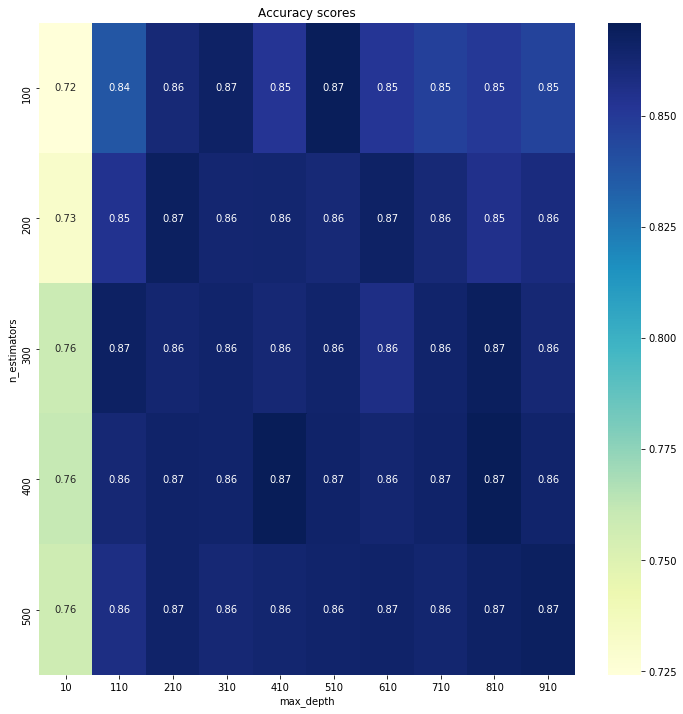

('Best parameters', {'n_estimators': 400, 'max_depth': 410}, 'with validation accuracy :', 0.87091069849690539)


In [11]:
gs_scores_df=pd.DataFrame(data=accuracy_scores,index=range(100,501,100),columns=range(10,1000,100))
plt.figure(figsize=(12,12))
ax = sns.heatmap(gs_scores_df,cmap="YlGnBu",fmt='.2f',annot=True)
ax.set_ylabel('n_estimators')
ax.set_xlabel('max_depth')
ax.set_title('Accuracy scores')
plt.savefig('heatmap_random_forrest_parameter_search.png')
plt.show()
print("Best parameters", best_params, "with validation accuracy :", best_score)

It is clear that if we have more than 300 estimators and a depth of more than 200, we have similar scores.  
We will  use the best parameters we found but it could be argued that there are as good as the other good parameters since the difference in accuracy could be due to the overfitting of the parameter search to the validation set.  
The best parameters are for 400 estimators and a depth of 410. So we will look for parameters arround these values.

In [14]:
accuracy_scores=[]
best_params=dict()
best_score=0
# We try different values for the number of estimators
for n_estimators in range(300,501,50):
    sublist=[]
    # We try different depths
    for max_depth in range(300,501,10):
        rf_clf = RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth,n_jobs=-1)
        rf_clf.fit(x_train,y_train)
        score=accuracy_score(rf_clf.predict(x_val),y_val)
        # We keep track of the accuracy
        sublist.append(score)
        if score>best_score:
            best_score=score
            best_params['n_estimators']=n_estimators
            best_params['max_depth']=max_depth
            print("Current best estimators : n_estimators: "+str(n_estimators)+", max_depth: "+str(max_depth)+", score: "+str(score))
    accuracy_scores.append(sublist)

Current best estimators : n_estimators: 300, max_depth: 300, score: 0.862068965517
Current best estimators : n_estimators: 300, max_depth: 340, score: 0.869142351901
Current best estimators : n_estimators: 350, max_depth: 300, score: 0.870910698497
Current best estimators : n_estimators: 400, max_depth: 310, score: 0.871794871795
Current best estimators : n_estimators: 400, max_depth: 460, score: 0.872679045093
Current best estimators : n_estimators: 400, max_depth: 490, score: 0.877984084881


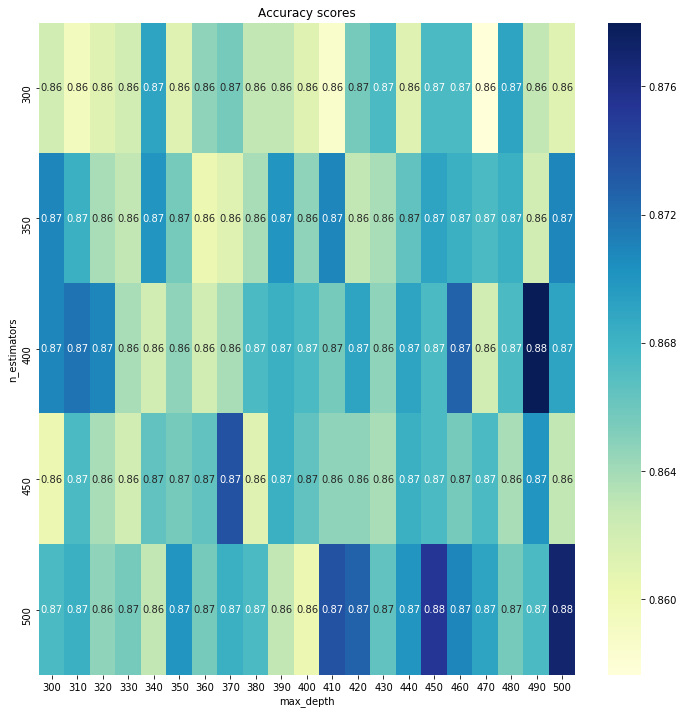

('Best parameters', {'n_estimators': 400, 'max_depth': 490}, 'with validation accuracy :', 0.87798408488063662)


In [16]:
gs_scores_df=pd.DataFrame(data=accuracy_scores,index=range(300,501,50),columns=range(300,501,10))
plt.figure(figsize=(12,12))
ax = sns.heatmap(gs_scores_df,cmap="YlGnBu",fmt='.2f',annot=True)
ax.set_ylabel('n_estimators')
ax.set_xlabel('max_depth')
ax.set_title('Accuracy scores')
plt.savefig('heatmap_random_forrest_parameter_search_zoom.png')
plt.show()
print("Best parameters", best_params, "with validation accuracy :", best_score)


We can see that the best parameters are 400 estimators with a maximum depth of 490.

We find the test accuracy for our best estimator

In [17]:
rf_clf = RandomForestClassifier(n_estimators=400,max_depth=490,n_jobs=-1)
rf_clf.fit(x_train,y_train)
y_pred = rf_clf.predict(x_test)
print("Testing accuracy :", accuracy_score(y_pred,y_test))

('Testing accuracy :', 0.86648983200707341)


As we can see this is worse than the validation accuracy because the grid search for the parameters overfitted the validation set (1%). Since it overfitted the validation set, we could use other parameters which had a similar score in the validation set and still get a similar or even better accuracy on the test set. 

Ploting the confusion matrix

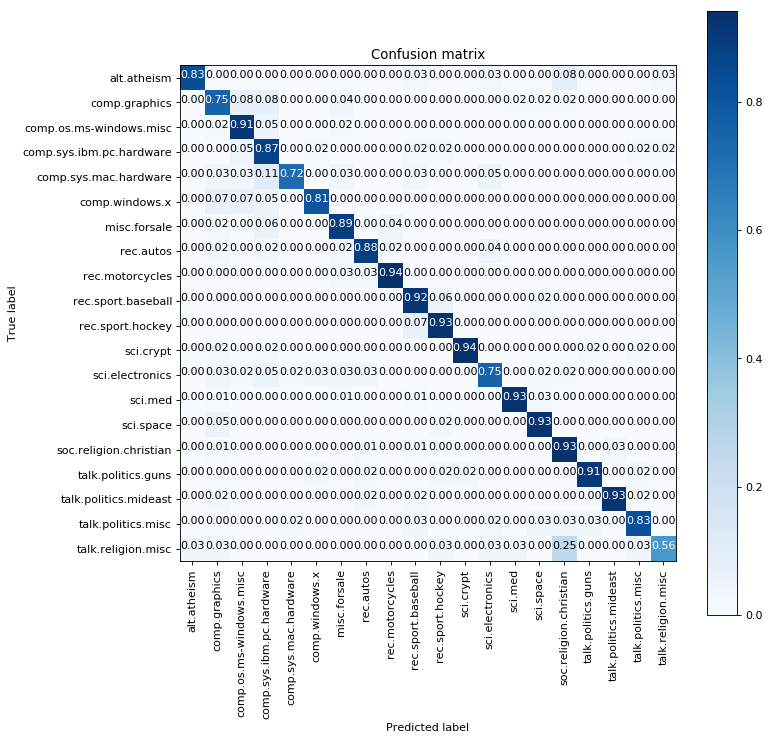

In [21]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure(figsize=(10, 10),dpi=80)

cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]

plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(list(newsgroups_train.target_names)))
plt.xticks(tick_marks, list(newsgroups_train.target_names), rotation=90)
plt.yticks(tick_marks, list(newsgroups_train.target_names))

fmt = '.2f'
thresh = cnf_matrix.max() / 2.
for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, format(cnf_matrix[i, j], fmt),
             horizontalalignment="center",
             color="white" if cnf_matrix[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.savefig("confusion_matrix.png")
plt.show()

As we can see, we have a relatively good accuracy. We are particularly good at predicting for example hockey, and talk.politics.mideast.  
We sometimes predict talk.religion.misc as soc.religion.christian (but not the other way arround) which is understandable.

We now plot the features' importances

/home/adrikiri/miniconda2/lib/python2.7/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


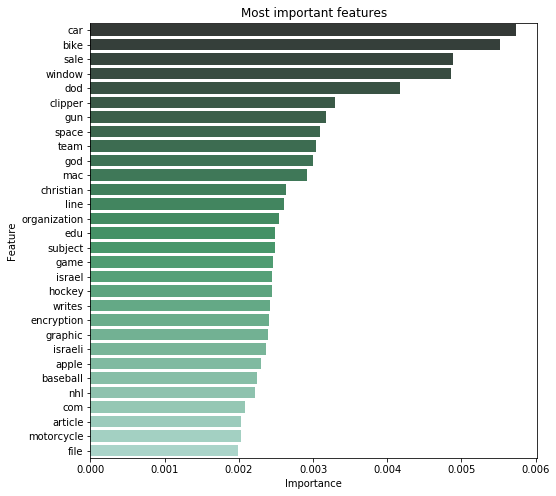

In [23]:
plt.figure(figsize=(8,8))
plotted_30_features = []
features = tfid_vectorizer.get_feature_names()
# Sort the features by importance
sorted_features_importance= sorted_features_importance = np.array(sorted(zip(rf_clf.feature_importances_.astype(np.float64),features)))[::-1]
ax=sns.barplot(x=sorted_features_importance[:30][:,0].astype(np.float64),
            y=sorted_features_importance[:30][:,1],palette="BuGn_d")
ax.set_title("Most important features")
ax.set_ylabel("Feature")
ax.set_xlabel("Importance")
plt.show()

These are the words that are the most important in deciding to which category a article belongs. As we can see, these are words that are usually used extensively in a specific category such as car, gun, baseball, hockey, god, apple, space...